
# **Image Enhancement**



In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,GlobalAveragePooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape,Dense,Multiply
from keras.models import Model
from keras.utils import plot_model
from IPython.display import Image
from tqdm import tqdm
np.random.seed(1)

## Attach to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
InputPath = "/content/drive/MyDrive/LOLdataset/our485/high"

## Noise Addition

In [4]:
def addNoise(image):
    """
    Args:
        image: The input image.

    Returns:
        The image with added noise.
    """
    noiseAddedImage = np.copy(image)
    rows, cols, channels = image.shape
    num_noise_pixels = int(np.ceil(rows * cols * 0.5))

    # random coordinates for noise pixels
    coords_row = np.random.randint(0, rows, num_noise_pixels)
    coords_col = np.random.randint(0, cols, num_noise_pixels)

    # Adding noise to each channel separately
    for channel in range(channels):
        noiseAddedImage[coords_row, coords_col, channel] = 1

    return noiseAddedImage

Text(0.5, 1.0, 'Noisy Image')

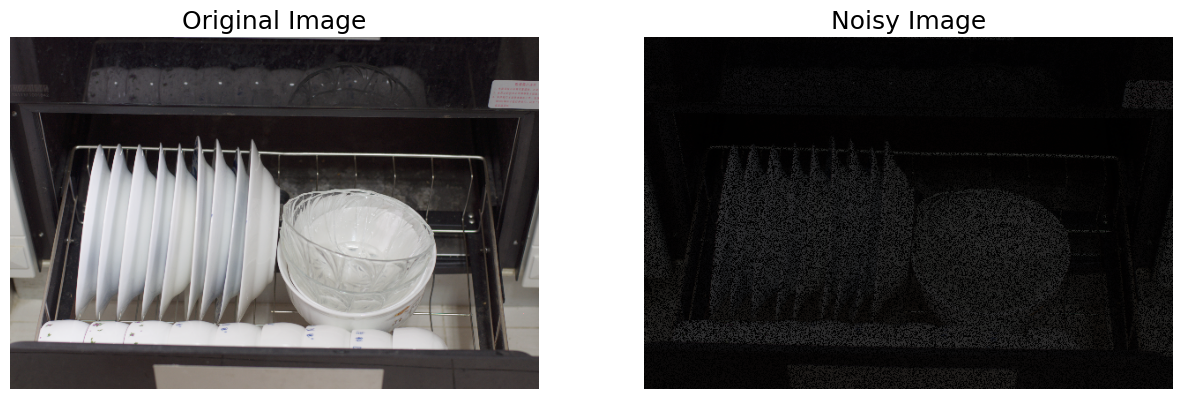

In [5]:
# Exaple case of Noise Addition

img = cv.imread(InputPath+"/100.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image",fontsize=18)

plt.subplot(1,2,2)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise = addNoise(img1)
plt.imshow(Noise)
plt.axis('off')
plt.title("Noisy Image",fontsize=18)

## Data Preprocessing

In [6]:
HighPath = "/content/drive/MyDrive/LOLdataset/our485/high"

In [7]:
def PreProcessData(ImagePath):
    """
    Pre-process images by creating low-light versions and adding noise.

    Args:
        HighPath (str): The directory path containing high-quality input images.

    Returns:
        tuple: A tuple containing:
            - X_ (np.ndarray): An array of noisy low-light images.
            - y_ (np.ndarray): An array of original high-quality images.
    """
    X_=[]
    y_=[]
    count=0
    for imageName in tqdm(os.listdir(HighPath)):
        count=count+1
        image_path = os.path.join(HighPath, imageName)

        # Checking if the file exists and is an image
        if os.path.isfile(image_path) and imageName.lower().endswith(('.png', '.jpg', '.jpeg')):
            low_img = cv.imread(image_path)
            # Checking if the image is loaded successfully
            if low_img is not None:
                low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)
                low_img = cv.resize(low_img,(500,500))
                hsv = cv.cvtColor(low_img, cv.COLOR_BGR2HSV)
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = addNoise(img_1)
                X_.append(Noisey_img)
                y_.append(low_img)
            else:
                print(f"Warning: Could not load image: {image_path}")
        else:
            print(f"Warning: Skipping non-image file: {imageName}")

    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [8]:
X_,y_ = PreProcessData(InputPath)

 16%|█▌        | 80/495 [00:15<00:15, 26.43it/s]

100%|██████████| 495/495 [00:29<00:00, 16.53it/s]


## Model Building

In [9]:
K.clear_session()
def InstantiateModel(in_):
    """
    Instantiate a convolutional neural network model for image enhancement.

    Args:
        in_ (tf.Tensor): The input tensor, typically representing a batch of images.

    Returns:
        tf.Tensor: The output tensor of the model, representing the enhanced images.
    """
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5

In [10]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)

## Model Compilation and Summary

In [11]:
model = Model(inputs=Input_Sample, outputs=Output_)
model.compile(optimizer="adam", loss='mean_squared_error')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500, 500, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 500, 500, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 500, 500, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 500, 500, 32)   │          4,640 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 500, 500, 64)   │          8,256 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 500, 500, 64)   │          8,256 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 500, 500, 64)   │         16,448 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 500, 500, 64)   │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 500, 500, 64)   │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 500, 500, 32)   │         18,464 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 500, 500, 32)   │         18,464 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 500, 500, 16)   │          2,064 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 500, 500, 16)   │          4,112 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 500, 500, 16)   │          2,064 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 500, 500, 16)   │              0 │ conv2d_10[0][0],       │
│                           │                        │                │ conv2d_11[0][0],       │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 500, 500, 16)   │          9,232 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 500, 500, 16)   │          2,320 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)          

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

## Model Architecture

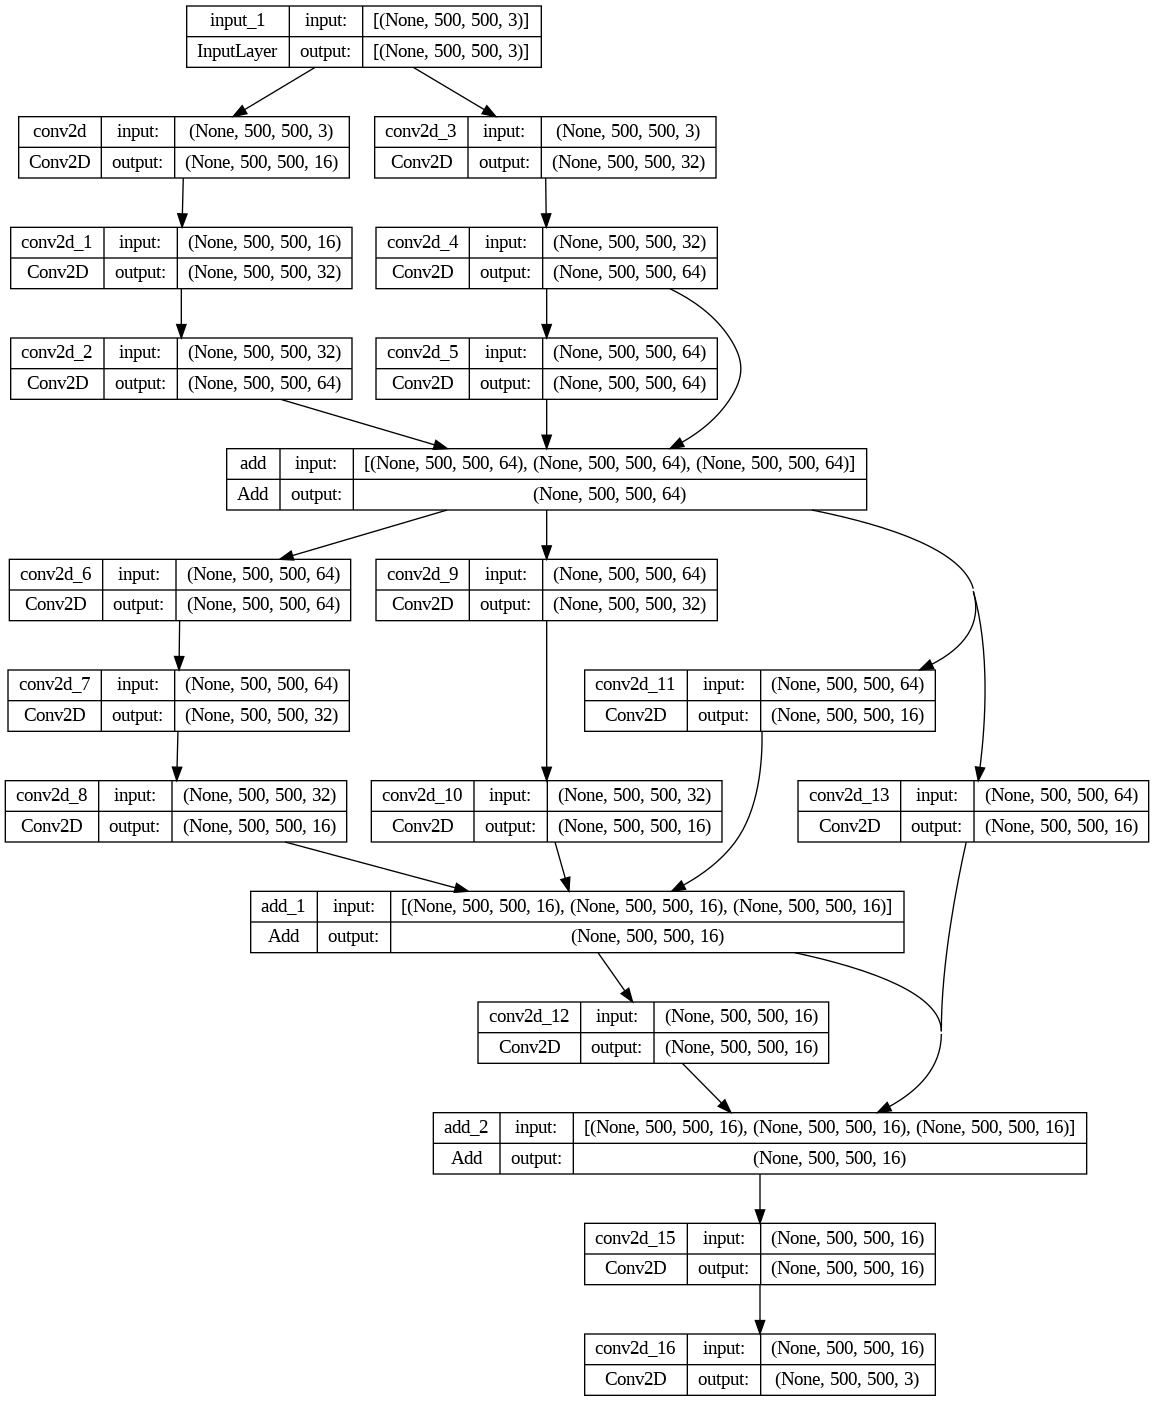

In [ ]:
plot_model(model,to_file='model_.png',show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_.png')

## Training

In [12]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)

In [14]:
hist = model.fit(GenerateInputs(X_,y_),epochs=20,verbose=1,steps_per_epoch=8,shuffle=True)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 94.3792
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 115.6714
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 46.5757
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 95.8740
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 120.7589
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 93.2491
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 131.1832
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 94.6323
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 85.8443
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 123.0021
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 67.9613
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 81.5484
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 88.9389
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 81.0730
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 60.3085
Epoch 16/20
8/8

In [15]:
TestPath="/content/drive/MyDrive/LOLdataset/eval15/high"

In [16]:
def ExtractTestInput(ImagePath):
    """
    Extract and preprocess a test image for input into the model.

    Args:
        ImagePath (str): The file path to the input image.

    Returns:
        np.ndarray: A preprocessed image with added noise, reshaped for model input.
    """
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV)
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(-0.5, 499.5, 499.5, -0.5)

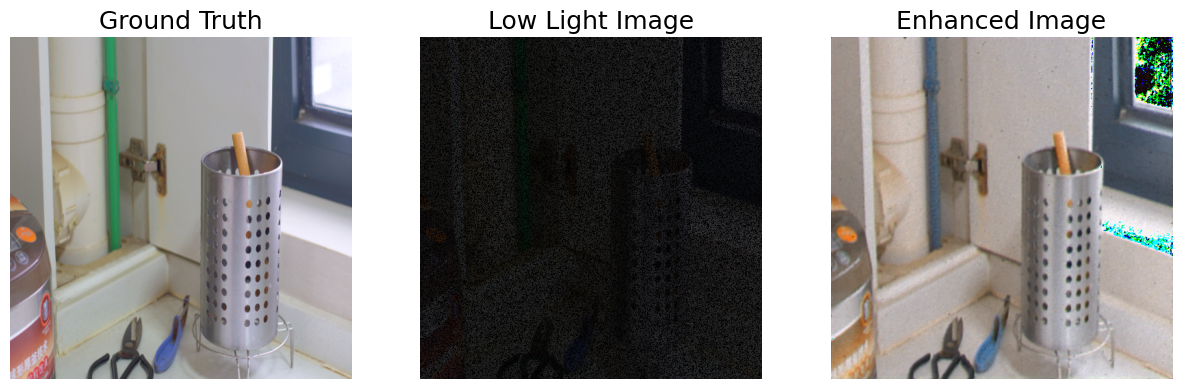

In [17]:
ImagePath=TestPath+"/111.png"

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=18)
plt.imshow(img_1)
plt.axis('off')

plt.subplot(1,3,2)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=18)
plt.imshow(img_)
plt.axis('off')

plt.subplot(1,3,3)
image_for_test = ExtractTestInput(ImagePath)
Prediction = model.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=18)
plt.imshow(img_)
plt.axis('off')

## Postprocessing

In [18]:
def sharpen_image(image):
    image_float = image.astype(np.float32)
    blurred = cv.GaussianBlur(image_float, (5, 5), 1.5)

    # Creating sharpened image by subtracting the blurred image from the original
    sharpened = cv.addWeighted(image_float, 1.5, blurred, -0.5, 0)

    # Clip the values to be in the range [0, 255] for uint8
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    return sharpened

In [19]:
def color_correction(image):
    hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    h_channel, s_channel, v_channel = cv.split(hsv)

    # Normalize the saturation channel
    s_channel = cv.normalize(s_channel, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

    # Optionally enhance value (brightness) channel
    v_channel = cv.normalize(v_channel, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

    hsv_corrected = cv.merge((h_channel, s_channel, v_channel))
    corrected_image = cv.cvtColor(hsv_corrected, cv.COLOR_HSV2RGB)
    return corrected_image

In [20]:
def denoise_image(image):
    return cv.fastNlMeansDenoisingColored(image, None, 5, 5, 10, 10)

def gamma_correction(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv.LUT(image, table)

In [21]:
def combined_post_processing(image):

    image = sharpen_image(image)

    image = color_correction(image)

    image = denoise_image(image)

    image = gamma_correction(image, gamma=1.1)

    return image

In [24]:
def display_image(ImagePath):
    """
    Display the original, low-light image, enhanced image, and post-processed image.

    Args:
        ImagePath (str): The file path to the input image.
    """

    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    img_1 = cv.imread(ImagePath)
    img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
    img_1 = cv.resize(img_1, (500, 500))
    plt.title("Ground Truth",fontsize=18)
    plt.imshow(img_1)
    plt.axis('off')

    plt.subplot(1,4,2)
    img_ = ExtractTestInput(ImagePath)
    img_ = img_.reshape(500,500,3)
    plt.title("Low Light Image",fontsize=18)
    plt.imshow(img_)
    plt.axis('off')

    plt.subplot(1,4,3)
    image_for_test = ExtractTestInput(ImagePath)
    Prediction = model.predict(image_for_test)
    Prediction = Prediction.reshape(500,500,3)
    img_[:,:,:] = Prediction[:,:,:]
    plt.title("Enhanced Image",fontsize=18)
    plt.imshow(img_)
    plt.axis('off')

    plt.subplot(1,4,4)
    ppi = combined_post_processing(Prediction)
    plt.title("Post Processed Image",fontsize=18)
    plt.imshow(ppi)
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


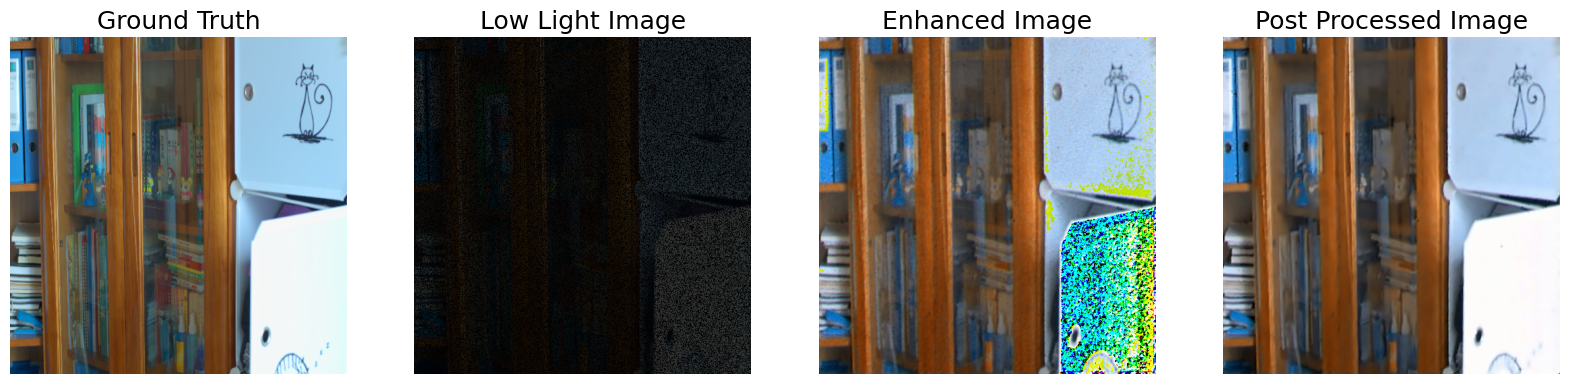

In [25]:
ImagePath=TestPath+"/1.png"

display_image(ImagePath)